## APhys Group Meeting (7/10/25)

Estimating fluxes and net transport across Lake Zug constriction.

2025 has different file structure, don't worry about for now.

All 2024 ADCPs have pressure data, use the ADCP measured depth.

All attributes have orientation up, manually determine orientation from notes
- The up ADCPs have greater depth than the down ADCPs for 2/3 moorings?

In [20]:
# imports
import os
from glob import glob
import dolfyn as dlfn
import xarray as xr
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings('ignore')

In [2]:
year_date = [('2024', '20240424'), ('2024', '20240719'), ('2024', '20241017')]
location = 'LZ2'
data_dir = 'Q:/Messdaten/Aphys_hypothesis_data/Zugersee/{year}/Mooring/{location}/{date}/'
md_path = ['Q:/Messdaten/Aphys_hypothesis_data/Zugersee/{year}/Mooring/{location}/{date}/{date}_{location}_meta.tsv',
           'Q:/Messdaten/Aphys_hypothesis_data/Zugersee/{year}/Mooring/{location}/{date}/Notes.txt']

# Lake Zug bathymetry
bathy = xr.open_dataset('../../../../data/lake_zug/bathymetry/zugersee_bathy.nc')

In [67]:
def locate_md_file(md_path, year, date, location):
    for wildcard_path in md_path:
        md_file = wildcard_path.format(year=year, location=location, date=date)
        if os.path.exists(md_file):
            return md_file
        
    raise FileNotFoundError(f'Could not locate metadata file for mooring {location}, date {date}')


# parse metadata file for Switzerland coordinates
def read_md_file(md_file):
    _, ext = os.path.splitext(md_file)

    if ext == '.tsv':
        md = pd.read_csv(md_file, sep='\t')[f'Mooring: {location}']
        lon_mask = md.str.startswith('Longitude').fillna(False)
        lat_mask = md.str.startswith('Latitude').fillna(False)
        xsc = int(md.loc[lon_mask].iloc[0].split()[-1]) + int(2e6)
        ysc = int(md.loc[lat_mask].iloc[0].split()[-1]) + int(1e6)


    elif ext == '.txt':
        with open(md_file, 'r') as f:
            lines = f.read().splitlines()

            for l in lines:
                if 'coord' in l:
                    _, xsc, ysc = l.split()
                    break

        xsc = int(xsc) + int(2e6)
        ysc = int(ysc) + int(1e6)
    
    else:
        raise ValueError('Metadata file should be .tsv or .txt')
    
    return {'xsc': xsc, 'ysc': ysc}


def gather_adcp_attrs(ds, depth=None):
    serial_id = str(ds.attrs['serialnum'])
    freq = ds.attrs['freq']
    bin_size = ds.attrs['cell_size']

    # conditionals correct for 2024 moorings (I THINK)
    if serial_id == '16576':
        orient = 'up'
    elif serial_id == '24399':
        orient = 'down'
    else:
        orient = ds.attrs['orientation']

    # if ADCP measure pressure, use ADCPs depth
    if 'pressure' in ds.data_vars and not depth:
        depth = ds.depth.where(ds.depth != 0, drop=True).mean().item()
    else:
        raise ValueError('ADCP does not measure pressure, use manual depth measurement.')

    return {'serial_id': serial_id, 'freq': freq, 'bin_size': bin_size, 'orient': orient, 'depth': depth}


def omit_downupcast_time(ds):
    dt_min = ds.time.min().values
    dt_max = ds.time.max().values
    dt_start = dt_min + pd.Timedelta(hours=12)
    dt_end = dt_max - pd.Timedelta(hours=6)

    # select timeframe excluding downcast and upcast
    return ds.sel(time=slice(dt_start, dt_end)), dt_start, dt_end


# update range relative to depth
def range_to_depth(ds, attrs):
    if attrs['orient'] == 'down':
        ds['range'] = attrs['depth'] + ds.range.values
    elif attrs['orient'] == 'up':
        ds['range'] = attrs['depth'] - ds.range.values

    return ds


#  interface detection


# minimum correlation
# flag data with at least 1 beam correlation < 64
def qa_min_corr(ds, corr_thresh=64):
    corr1 = ds.corr.sel(beam=1) >= corr_thresh
    corr2 = ds.corr.sel(beam=2) >= corr_thresh
    corr3 = ds.corr.sel(beam=3) >= corr_thresh
    corr4 = ds.corr.sel(beam=4) >= corr_thresh

    return ds.where(corr1 & corr2 & corr3 & corr4)


# minimum good data percentage
# flag data with PG1 + PG4 < 25%
def qa_pg14(ds, pg14_thresh=25):
    pg14 = ds.prcnt_gd.sel(beam=1) + ds.prcnt_gd.sel(beam=4)

    return ds.where(pg14 >= pg14_thresh)


# maximum bad data percentage
# flag data with PG3 > 25%
def qa_pg3(ds, pg3_thresh = 25):
    pg3 = ds.prcnt_gd.sel(beam=3)

    return ds.where(pg3 <= pg3_thresh)


# maximum velocity error
# flag data with velocity error > 0.05 m/s


# maximum tilt
# flag data with pitch or roll angle > 15°


# maxmimum 4-beams correlation difference
# flag data with differences in correlation ratio with standard deviation > 0.01


# minimum vertical echo difference (only required if beam reaches bottom or surface)
# flag data with at least one beam with vertical echo difference between consecutive bins > 30
def qa_echo_amp_diff(ds, ead_thresh=30):
    echo_amp_diff = ds.amp.diff(dim='range')
    ead1 = echo_amp_diff.sel(beam=1) <= ead_thresh
    ead2 = echo_amp_diff.sel(beam=2) <= ead_thresh
    ead3 = echo_amp_diff.sel(beam=3) <= ead_thresh
    ead4 = echo_amp_diff.sel(beam=4) <= ead_thresh

    return ds.where(ead1 & ead2 & ead3 & ead4)
    


In [175]:
def estimate_flux(ds, md, attrs, bathy, xsc_w=2679500):
    # slice coronal cross-section at location of mooring
    coronal = bathy.sel(ysc=md['ysc'])

    # north-south velocity
    v = ds.vel.sel(dir='N')

    flux_data = []
    # iterate over depths
    for d in v.range.values:
        # condition on depth between surface and bottom
        if d > 0 and d < md['total_depth']:
            # mask xsc with depth > level
            mask = coronal.depth > d

            # first and last xsc coordinates at this depth
            idx_w = np.where(mask)[0][0]
            idx_e = np.where(mask)[0][-1]

            # width of constriction at this depth
            xw = coronal.xsc[idx_w].item()
            if xw < xsc_w:     # constain to only constriction passage
                xw = xsc_w
            xe = coronal.xsc[idx_e].item()
            width = xe - xw

            # area of rectangle
            da = width * attrs['bin_size']

            # flux = velocity * cross-section area
            flux = (v.sel(range=d) * da).rename('flux')
            flux_data.append(flux)


    flux_data = xr.concat(flux_data, dim='range')
    flux_data = flux_data.rename({'range': 'depth'})
    flux_data = flux_data.sortby('depth', ascending=True)

    return flux_data

In [176]:
flux_data = []
all_md = []
all_attrs = []
for (year, date) in year_date:
    root = data_dir.format(year=year, location=location, date=date)
    md_file = locate_md_file(md_path, year, date, location)
    md = read_md_file(md_file)
    md['total_depth'] = bathy.sel(xsc=md['xsc'], ysc=md['ysc']).depth.item()
    all_md.append(md)

    adcps = [os.path.join(root, a) for a in glob('*.000', root_dir=root)]
    flux_mooring = []

    for adcp in tqdm(adcps):
        ds = dlfn.read(adcp)
        attrs = gather_adcp_attrs(ds)
        
        
        ds, dt_start, dt_end = omit_downupcast_time(ds)
        attrs['dt_start'] = dt_start
        attrs['dt_end'] = dt_end
        all_attrs.append(attrs)
        ds = range_to_depth(ds, attrs)

        # quality assurance
        ds = qa_min_corr(ds, corr_thresh=64)
        ds = qa_pg14(ds, pg14_thresh=25)
        ds = qa_pg3(ds, pg3_thresh = 25)
        ds = qa_echo_amp_diff(ds, ead_thresh=30)

        flux = estimate_flux(ds, md, attrs, bathy)
        flux_mooring.append(flux)


    flux_mooring = xr.concat(flux_mooring, dim='depth')
    flux_data.append(flux_mooring)

  0%|          | 0/2 [00:00<?, ?it/s]


Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2024/Mooring/LZ2/20240424/2_300000.000 ...

Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2024/Mooring/LZ2/20240424/2_600000.000 ...


  0%|          | 0/2 [00:00<?, ?it/s]


Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2024/Mooring/LZ2/20240719/DPL3_000.000 ...

Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2024/Mooring/LZ2/20240719/DPL4_000.000 ...


  0%|          | 0/2 [00:00<?, ?it/s]


Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2024/Mooring/LZ2/20241017/3D576000.000 ...

Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2024/Mooring/LZ2/20241017/6U399000.000 ...


Location of constriction moorings.

We define the interface as the `ysc` value of the mooring.  A potential improvement would define the interface perpendicular to the shore.

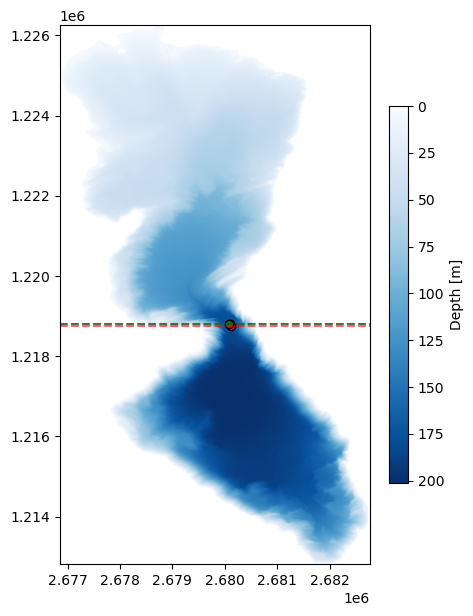

In [177]:
fig, ax = plt.subplots(figsize=(5, 7))
colors = ['purple', 'red', 'green']

im = ax.pcolormesh(bathy['xsc'], bathy['ysc'], bathy['depth'], cmap='Blues', vmin=0)
cbar = fig.colorbar(im, shrink=0.7, label='Depth [m]', ax=ax)
cbar.ax.invert_yaxis()

for i, md in enumerate(all_md):
    ax.axhline(md['ysc'], c=colors[i], ls='--', alpha=0.6)
    ax.scatter(md['xsc'], md['ysc'], c=colors[i], edgecolor='black')

plt.show()

We can take a coronal slice at the interface to get the cross-section profile.  Notice the interface includes some of the North basin, which we omit by defining a western x boundary, as N-S fluxes here do not interchange basins.

Here we plot the depth of the ADCPs in the cross-section and their range.

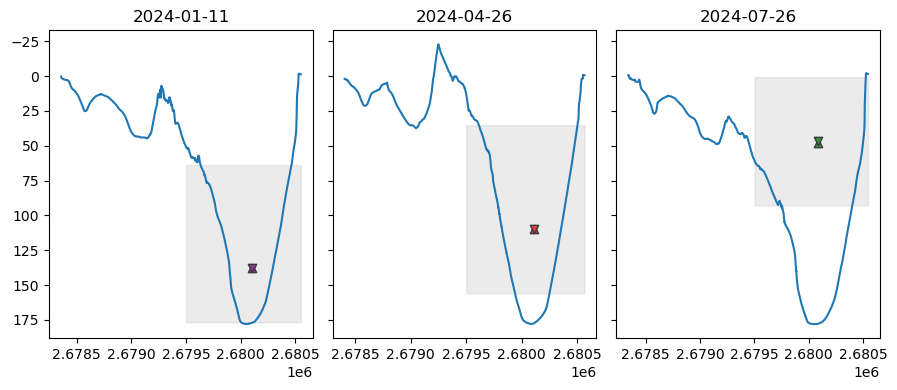

In [178]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 4), sharey=True)
colors = ['purple', 'red', 'green']
xsc_w = 2679500

for i, md in enumerate(all_md):
    coronal = bathy.sel(ysc=md['ysc'])
    ax[i].plot(coronal.xsc, coronal.depth)

    attrs1, attrs2 = all_attrs[2*i: 2*i + 2]
    ax[i].scatter(md['xsc'], attrs1['depth'], c=colors[i], edgecolor='black', marker='^')
    ax[i].scatter(md['xsc'], attrs2['depth'], c=colors[i], edgecolor='black', marker='v')

    d_min = flux_data[i].depth.min().item()
    d_max = flux_data[i].depth.max().item()

    ax[i].fill_between(coronal.xsc[(coronal.depth.notnull()) & (coronal.xsc > xsc_w)], d_min, d_max, color='silver', alpha=0.3)

    ax[i].set_title(attrs1['dt_start'].date())

ax[0].invert_yaxis()

plt.tight_layout()
plt.show()

More specifically, for each depth bin the ADCPs record, we create a 'Riemann' rectangle that captures the width of the constriction at the given depth.  We calculate the flux at this depth as the velocity field multiplied by the area of the rectangle.

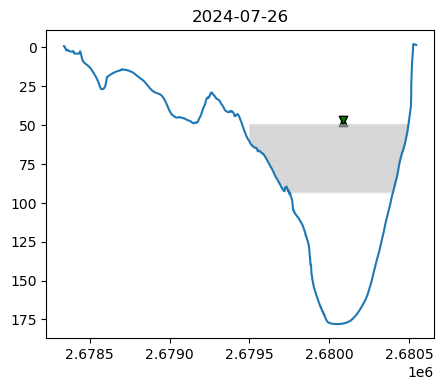

In [207]:
v = ds.vel.sel(dir='N')
coronal = bathy.sel(ysc=all_md[-1]['ysc'])
xsc_w = 2679500

fig, ax = plt.subplots(figsize=(5, 4))

ax.plot(coronal.xsc, coronal.depth)

attrs1, attrs2 = all_attrs[-2:]
ax.scatter(all_md[-1]['xsc'], attrs1['depth'], c='green', edgecolor='black', marker='^')
ax.scatter(all_md[-1]['xsc'], attrs2['depth'], c='green', edgecolor='black', marker='v')

for d in v.range.values:
    # condition on depth between surface and bottom
    if d > 0 and d < all_md[-1]['total_depth']:
        # mask xsc with depth > level
        mask = coronal.depth > d

        # first and last xsc coordinates at this depth
        idx_w = np.where(mask)[0][0]
        idx_e = np.where(mask)[0][-1]

        # width of constriction at this depth
        xw = coronal.xsc[idx_w].item()
        if xw < xsc_w:     # constain to only constriction passage
            xw = xsc_w
        xe = coronal.xsc[idx_e].item()
        
        ax.fill_between(np.arange(xw, xe+1), d - (attrs2['bin_size']/2), d + (attrs2['bin_size']/2), color='silver', alpha=0.3)
        

ax.set_title(attrs1['dt_start'].date())
ax.invert_yaxis()
plt.show()

In [232]:
data = []
for i, flux_mooring in enumerate(flux_data):
    dat = flux_mooring.to_dataframe().reset_index()
    attrs1, attrs2 = all_attrs[2*i: 2*i + 2]
    dat['dt_start'] = attrs1['dt_start'].date()
    data.append(dat)

data = pd.concat(data, ignore_index=True)
data['day'] = data['time'].dt.date

For each day and depth, calculate the average flux.  Group depths into bins of 10 meters.  Plot daily average flux as a function of depth bin.

In [275]:
data_avg = data.groupby(['dt_start', 'day', 'depth'], sort=False)['flux'].mean().reset_index()
data_avg['depth_bin'] = data_avg['depth'] // 10
data_avg = data_avg[data_avg['flux'].abs() < 10]

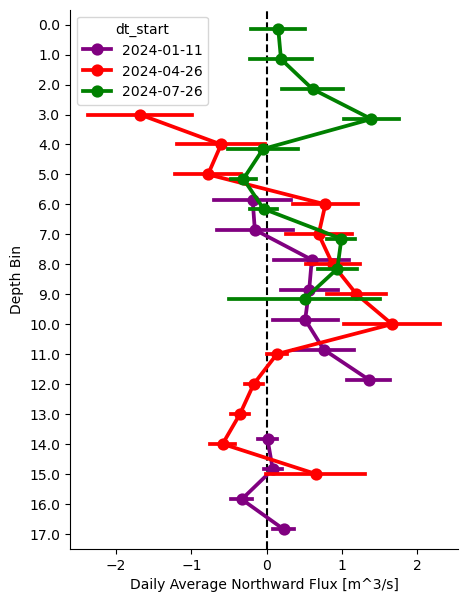

In [281]:
fig, ax = plt.subplots(figsize=(5, 7))
palette = ['purple', 'red', 'green']

ax.axvline(0, color='black', ls='--')
sns.pointplot(data_avg, x='flux', y='depth_bin', orient='h', hue='dt_start', hue_order=data_avg.dt_start.unique(),
              palette=palette, errorbar=('se', 1), dodge=0.3, ax=ax)

ax.set_xlabel('Daily Average Northward Flux [m^3/s]')
ax.set_ylabel('Depth Bin')
ax.spines[['right', 'top']].set_visible(False)
plt.show()

For each day and depth, calculate the sum of all flux observations.  Group depths into bins of 10 meters.  Then, for each depth bin, calculate the proportion of days with a net Northward/Southward transport.  Define relative propotion as the proprotion of days with a net Northward transport - 0.5 (to center on 0).  Plot relative proportion of days with net Nortward transport as a function of depth bin.

The idea here is to compare the two plots to try to identify suspicous data and large transport events.  If a depth bin has a daily average transport direction that is consistent with the typical flow direction, that is expected (see green, depth bin 3).  However, if the daily average transport has a large errorbar and the average direction does not align with the typical flow direction, we can deduce either some suspect data (see red, depth bin 15) or a potential large transport event (purple, depth bin 12).

In [307]:
data_sum = data.groupby(['dt_start', 'day', 'depth'], sort=False)['flux'].sum().reset_index()
data_sum['depth_bin'] = data_sum['depth'] // 10
data_sum['direction'] = ['N' if x > 0 else 'S' for x in data_sum.flux]

df = data_sum.groupby(['dt_start', 'depth_bin'], sort=False)['direction'].value_counts(normalize=True).reset_index()
df['relative_proportion'] = df['proportion'] - 0.5

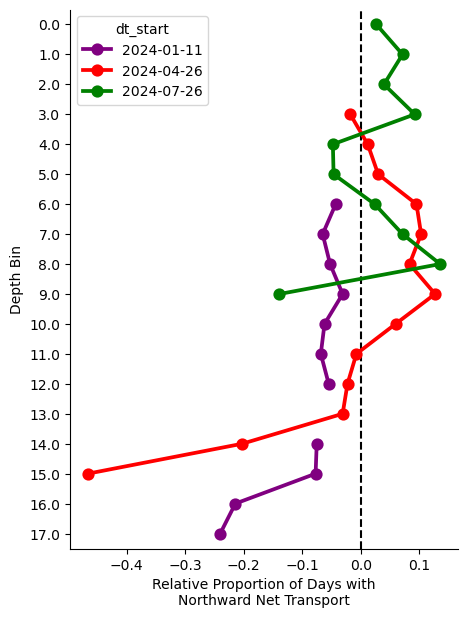

In [308]:
fig, ax = plt.subplots(figsize=(5, 7))
palette = ['purple', 'red', 'green']

ax.axvline(0, color='black', ls='--')
sns.pointplot(df.query('direction == "N"'), x='relative_proportion', y='depth_bin', orient='h', hue='dt_start',
            hue_order=df.dt_start.unique(), palette=palette, ax=ax)

ax.set_xlabel('Relative Proportion of Days with\nNorthward Net Transport')
ax.set_ylabel('Depth Bin')

ax.spines[['right', 'top']].set_visible(False)

plt.show()

Main takeaway is we only have velocity measurments from one column of water, and we are making lots of guesses (or really not any guesses at all) about the magnitude and direction of water across the rest of the constriction cross section.

Ways to improve estimates
- Consult model predictions
- Install more moorings in the constriction